#### Curve Fitting on IERS Bulletin A Data

In [1]:
from datetime import datetime, timedelta
from dataclasses import dataclass

from analyzer import (
  sanity_checks, read_header_cvs, read_final_value_cvs, read_rapid_service_cvs
)

assert sanity_checks()

In [2]:
# Read the tai_utc values from the header data.
TaiUtc = tuple[float, datetime] # (tai_utc, tai_utc_effective_dt)

def parse_tai_utc(h) -> TaiUtc:
  return h.tai_utc, h.tai_utc_effective

tai_utc_pairs = sorted(set(map(parse_tai_utc, read_header_cvs())), key=lambda p: p[1])

import pprint
pprint.pprint(tai_utc_pairs)

print()
print('I believe "(33.0, datetime.datetime(1999, 1, 1, 0, 0))" is a typo in the IERS file, so we discard it.')
print()

rmv_idx = tai_utc_pairs.index((33.0, datetime(1999, 1, 1, 0, 0)))
tai_utc_pairs.pop(rmv_idx)
pprint.pprint(tai_utc_pairs)

[(32.0, datetime.datetime(1999, 1, 1, 0, 0)),
 (33.0, datetime.datetime(1999, 1, 1, 0, 0)),
 (33.0, datetime.datetime(2006, 1, 1, 0, 0)),
 (34.0, datetime.datetime(2009, 1, 1, 0, 0)),
 (35.0, datetime.datetime(2012, 7, 1, 0, 0)),
 (36.0, datetime.datetime(2015, 7, 1, 0, 0)),
 (37.0, datetime.datetime(2017, 1, 1, 0, 0))]

I believe "(33.0, datetime.datetime(1999, 1, 1, 0, 0))" is a typo in the IERS file, so we discard it.

[(32.0, datetime.datetime(1999, 1, 1, 0, 0)),
 (33.0, datetime.datetime(2006, 1, 1, 0, 0)),
 (34.0, datetime.datetime(2009, 1, 1, 0, 0)),
 (35.0, datetime.datetime(2012, 7, 1, 0, 0)),
 (36.0, datetime.datetime(2015, 7, 1, 0, 0)),
 (37.0, datetime.datetime(2017, 1, 1, 0, 0))]


In [3]:
Ut1Utc = tuple[float, datetime] # (ut1_utc, datetime)

def mjd_to_dt(mjd: int) -> datetime:
  zero_point = datetime(1858, 11, 17, 0, 0, 0)
  return zero_point + timedelta(days=mjd)

def parse_final_value(fv) -> Ut1Utc:
  return fv.ut1_utc, mjd_to_dt(fv.mjd)

final_value_pairs = sorted(set(map(parse_final_value, read_final_value_cvs())), key=lambda p: p[1])
len(final_value_pairs)

7118

In [4]:
@dataclass
class DeltaT:
  year: float
  ut1_utc: float
  tai_utc: float
  delta_t: float


def dt_to_year(dt: datetime) -> float:
  year = dt.year
  year_length = datetime(year + 1, 1, 1).timestamp() - datetime(year, 1, 1).timestamp()
  past_length = dt.timestamp() - datetime(year, 1, 1).timestamp()
  return year + past_length / year_length

def find_tai_utc(dt: datetime) -> float:
  for tai_utc, tai_utc_effective_dt in reversed(tai_utc_pairs):
    if tai_utc_effective_dt <= dt:
      return tai_utc

delta_ts = []
for fv in final_value_pairs:
  ut1_utc, fv_dt = fv
  tai_utc = find_tai_utc(fv_dt)

  # Ref: https://webspace.science.uu.nl/~gent0113/deltat/deltat_modern.htm
  # delta_t = tai_utc - ut1_utc + 32.184
  delta_t = tai_utc - ut1_utc + 32.184

  delta_ts.append(DeltaT(
    year=dt_to_year(fv_dt),
    ut1_utc=ut1_utc,
    tai_utc=tai_utc,
    delta_t=delta_t
  ))

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
x_values = np.array([d.year for d in delta_ts])
y_values = np.array([d.delta_t for d in delta_ts])

assert len(x_values) == len(y_values)

print(f'Min year: {x_values.min()}')
print(f'Max year: {x_values.max()}')

Min year: 2004.8469945355191
Max year: 2024.4151867030967


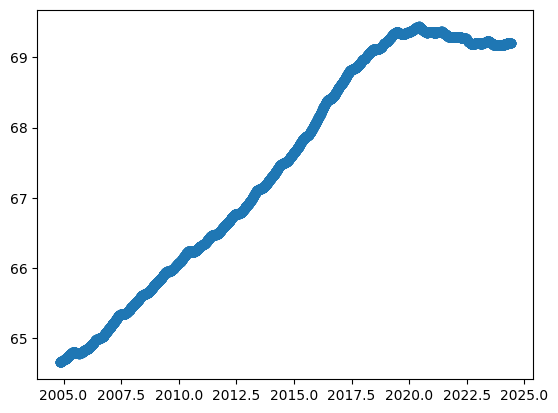

In [7]:
plt.scatter(x_values, y_values)
# Able to notice the outliers in the data

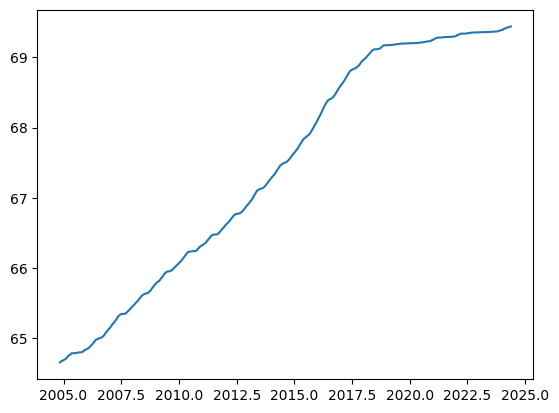

In [8]:
plt.plot(sorted(x_values[::19]), sorted(y_values[::19]))

In [9]:
# Filter out the outliers

import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

df = pd.DataFrame({'year': x_values, 'delta_t': y_values})

# Polynomial regression and fir the model.
degree = 3 # Simply use degree 3 here just for filtering.
years_poly = PolynomialFeatures(degree).fit_transform(df[['year']])

model = LinearRegression()
model.fit(years_poly, df['delta_t'])

# Predict the values and calculate the residuals.
delta_t_pred = model.predict(years_poly)
residuals = df['delta_t'] - delta_t_pred

# Define a threshold to identify outliers.
# Simply use 2 times the standard deviation of the residuals.
threshold = 2 * np.std(residuals)

# Filter out!
outliers = np.abs(residuals) > threshold
filtered_data = df[~outliers]

0 outliers removed.


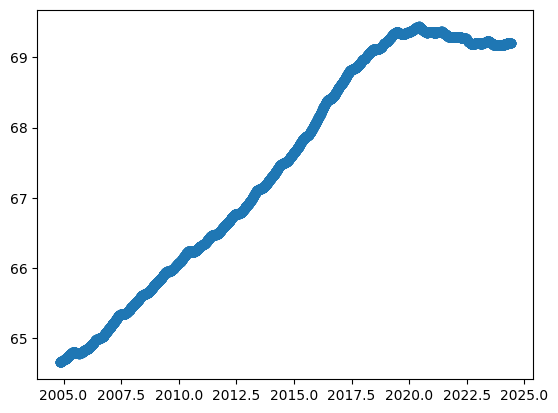

In [10]:
print(f'{len(df) - len(filtered_data)} outliers removed.')

plt.scatter(filtered_data['year'], filtered_data['delta_t'])

In [11]:
# Use scipy to find a polynomial that fits the data!

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, max_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def __poly(x, a, b, c, d, e, f, g, h):
  u = x - 1990
  return a + b / u + c * u + d * u**2 + e * u**3 + f * u**4 + g * u**5 + h * u**6

popt, pcov = curve_fit(__poly, filtered_data['year'], filtered_data['delta_t'])

print(popt)

def poly(x):
  return __poly(x, *popt)

print(f'r2        = {r2_score(filtered_data["delta_t"], poly(filtered_data["year"]))}')
print(f'mse       = {mean_squared_error(filtered_data["delta_t"], poly(filtered_data["year"]))}')
print(f'mae       = {mean_absolute_error(filtered_data["delta_t"], poly(filtered_data["year"]))}')
print(f'mape      = {mean_absolute_percentage_error(filtered_data["delta_t"], poly(filtered_data["year"]))}')
print(f'max_error = {max_error(filtered_data["delta_t"], poly(filtered_data["year"]))}')

[-1.53951040e+03  7.30508747e+03  1.16172057e+02 -1.12799103e+00
 -2.75480958e-01  1.54279686e-02 -3.33254809e-04  2.65410700e-06]
r2        = 0.9996631800017091
mse       = 0.000883173700993998
mae       = 0.023569581927838656
mape      = 0.000348269442798718
max_error = 0.09903018031658917


In [12]:
print(f'''
Coefficients:
  a = {popt[0]}
  b = {popt[1]}
  c = {popt[2]}
  d = {popt[3]}
  e = {popt[4]}
  f = {popt[5]}
  g = {popt[6]}
  h = {popt[7]}

Polynomial:
  u = x - 1990
  y = f(u) = {popt[0]} + {popt[1]} / u + {popt[2]} * u + {popt[3]} * u^2 + {popt[4]} * u^3 + {popt[5]} * u^4 + {popt[6]} * u^5 + {popt[7]} * u^6
''')


Coefficients:
  a = -1539.5103964825782
  b = 7305.087465383047
  c = 116.17205714035308
  d = -1.1279910329686536
  e = -0.2754809577876994
  f = 0.01542796862306066
  g = -0.0003332548091334704
  h = 2.6541070013360904e-06

Polynomial:
  u = x - 1990
  y = f(u) = -1539.5103964825782 + 7305.087465383047 / u + 116.17205714035308 * u + -1.1279910329686536 * u^2 + -0.2754809577876994 * u^3 + 0.01542796862306066 * u^4 + -0.0003332548091334704 * u^5 + 2.6541070013360904e-06 * u^6



Year: 2025, Predicted delta_t: 69.57495977217604
Year: 2026, Predicted delta_t: 70.71905480265286
Year: 2027, Predicted delta_t: 73.13620872698266
Year: 2028, Predicted delta_t: 77.51608301105534
Year: 2029, Predicted delta_t: 84.74986516176432


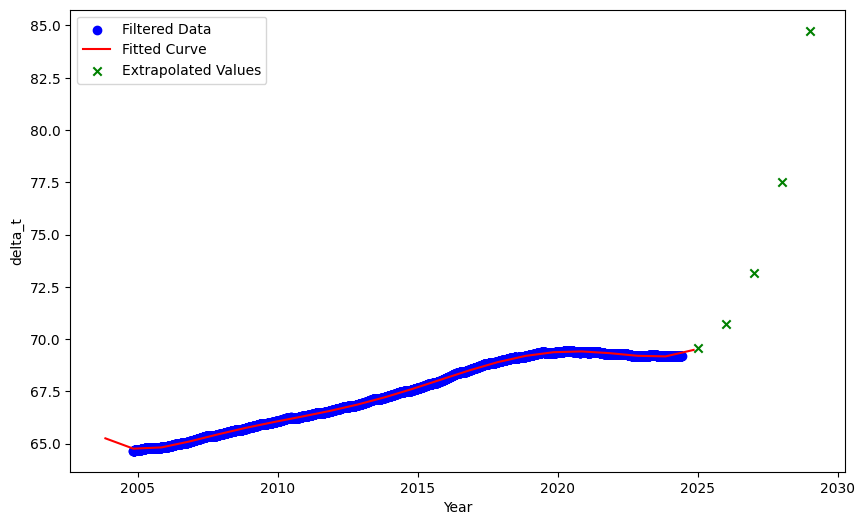

In [13]:
# Use the fitted model to predict the delta_t for future years.

future_years = np.arange(2025, 2030)
predicted_future_delta_t = poly(future_years)

for year, delta_t in zip(future_years, predicted_future_delta_t):
    print(f'Year: {year}, Predicted delta_t: {delta_t}')

# Plot the original data, the fitted curve, and the extrapolated values
plt.figure(figsize=(10, 6))

# Original data points
plt.scatter(filtered_data['year'], filtered_data['delta_t'], color='blue', label='Filtered Data')

# Fitted curve on the original data
years_range = np.arange(filtered_data['year'].min() - 1, filtered_data['year'].max() + 1)
fitted_curve = poly(years_range)
plt.plot(years_range, fitted_curve, color='red', label='Fitted Curve')

# Extrapolated values
plt.scatter(future_years, predicted_future_delta_t, color='green', label='Extrapolated Values', marker='x')

plt.xlabel('Year')
plt.ylabel('delta_t')
plt.legend()
plt.show()

# The fitted model has bad performance on the extrapolated values.

In [14]:
# Ref: https://maia.usno.navy.mil/ser7/deltat.preds

USNO_PREDICTION = '''
MJD	          Year	TT-UT	UT1-UTC	Error
59762.000	2022.50	69.29	-0.104	0.031
59853.000	2022.75	69.21	-0.025	0.021
59945.000	2023.00	69.21	-0.021	0.019
60036.000	2023.25	69.20	-0.020	0.021
60127.000	2023.50	69.18	 	0.024
60219.000	2023.75	69.11		0.027
60310.000	2024.00	69.11	 	0.033
60401.000	2024.25	69.11	 	0.043
60493.000	2024.50	69.10	 	0.056
60584.000	2024.75	69.03	 	0.070
60675.000	2025.00	69.04	 	0.088
60767.000	2025.25	69.07	 	0.109
60858.000	2025.50	69.06	 	0.133
60949.000	2025.75	69.01	 	0.159
61041.000	2026.00	69.05	 	0.189
61132.000	2026.25	69.09	 	0.223
61223.000	2026.50	69.11	 	0.257
61314.000	2026.75	69.09	 	0.291
61406.000	2027.00	69.14	 	0.327
61497.000	2027.25	69.21		0.367
61588.000	2027.50	69.26		0.408
61680.000	2027.75	69.26		0.446
61771.000	2028.00	69.34		0.486
61862.000	2028.25	69.44		0.525
61954.000	2028.50	69.51		0.566
62045.000	2028.75	69.54		0.603
62136.000	2029.00	69.63		0.637
62228.000	2029.25	69.75		0.672
62319.000	2029.50	69.83		0.711
62410.000	2029.75	69.87		0.742
62502.000	2030.00	69.97		0.768
62593.000	2030.25	70.08		0.794
62684.000	2030.50	70.17		0.823
62775.000	2030.75	70.21		0.849
62867.000	2031.00	70.32		0.871
62958.000	2031.25	70.42		0.891
63049.000	2031.50	70.51		0.913
63141.000	2031.75	70.53		0.926
63232.000	2032.00	70.62		0.937
63323.000	2032.25	70.72		0.952
63415.000	2032.50	70.82		0.975
63506.000	2032.75	70.86		1
63597.000	2033.00	70.98		1
63689.000	2033.25	71.10		1
63780.000	2033.50	71.20		1
63871.000	2033.75	71.25		1
'''

usno_lines = USNO_PREDICTION.strip().splitlines()[1:]

def parse_usno_line(line: str) -> tuple[float, float]:
  line = line.strip()
  splitted = line.split()
  assert len(splitted) in [4, 5]
  year = float(splitted[1])
  delta_t = float(splitted[2])
  return year, delta_t

usno_parsed = list(map(parse_usno_line, usno_lines))
usno_future_years = np.array([year for (year, _) in usno_parsed])
usno_future_delta_t = np.array([delta_t for (_, delta_t) in usno_parsed])

In [15]:
# Use scipy to curve-fit the usno prediction!

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, max_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def __pred_poly(x, a, b, c, d, e):
  u = x - 2020
  return a + b / u + c * u + d * u**2 + e * u**3


pred_popt, _ = curve_fit(__pred_poly, usno_future_years, usno_future_delta_t)

def pred_poly(x: float) -> float:
  return __pred_poly(x, *pred_popt)

print(pred_popt)

scipy_future_delta_t = pred_poly(usno_future_years)

print(f'r2        = {r2_score(usno_future_delta_t, scipy_future_delta_t)}')
print(f'max_error = {max_error(usno_future_delta_t, scipy_future_delta_t)}')
print(f'mse       = {mean_squared_error(usno_future_delta_t, scipy_future_delta_t)}')
print(f'mae       = {mean_absolute_error(usno_future_delta_t, scipy_future_delta_t)}')
print(f'mape      = {mean_absolute_percentage_error(usno_future_delta_t, scipy_future_delta_t)}')

[ 7.33807600e+01 -4.19976602e+00 -1.30536238e+00  1.41367711e-01
 -4.08671564e-03]
r2        = 0.998487355243141
max_error = 0.05866409260934802
mse       = 0.0007612049469331545
mae       = 0.02337720117426826
mape      = 0.000334747642232296


In [16]:
print(f'''
Coefficients:
a = {pred_popt[0]}
b = {pred_popt[1]}
c = {pred_popt[2]}
d = {pred_popt[3]}
e = {pred_popt[4]}

Polynomial:
u = x - 2020
y = f(u) = {pred_popt[0]} + {pred_popt[1]} / u + {pred_popt[2]} * u + {pred_popt[3]} * u^2 + {pred_popt[4]} * u^3
''')


Coefficients:
a = 73.38076003516039
b = -4.199766017124573
c = -1.3053623848472002
d = 0.14136771053009262
e = -0.004086715638812636

Polynomial:
u = x - 2020
y = f(u) = 73.38076003516039 + -4.199766017124573 / u + -1.3053623848472002 * u + 0.14136771053009262 * u^2 + -0.004086715638812636 * u^3



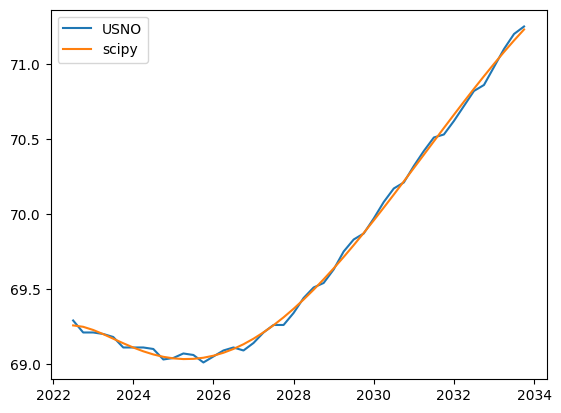

In [17]:
# Plot the results!
plt.plot(usno_future_years, usno_future_delta_t, label='USNO')
plt.plot(usno_future_years, scipy_future_delta_t, label='scipy')
plt.legend()

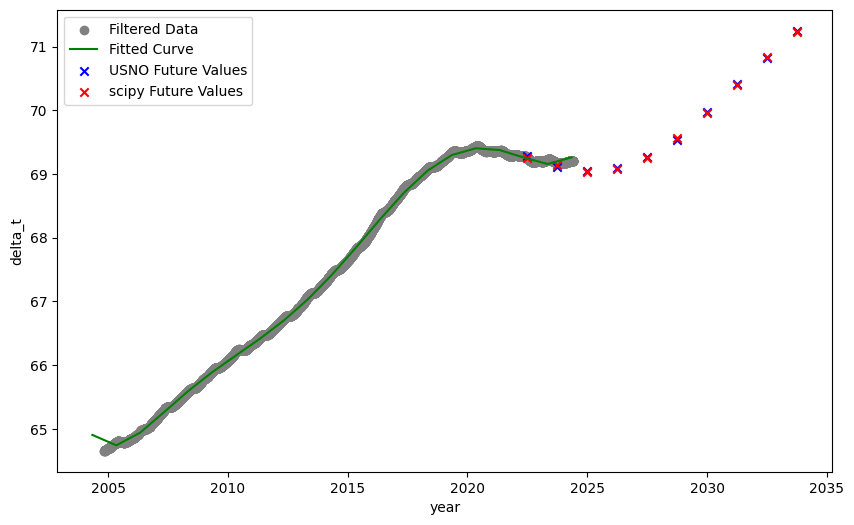

In [18]:
# Plot the original data, the fitted curve, and the future predicted values
plt.figure(figsize=(10, 6))

# Original data points
plt.scatter(filtered_data['year'], filtered_data['delta_t'], color='grey', label='Filtered Data')

# Fitted curve on the original data
years_range = np.arange(filtered_data['year'].min() - 0.5, filtered_data['year'].max() + 0.5)
fitted_curve = poly(years_range)
plt.plot(years_range, fitted_curve, color='green', label='Fitted Curve')

# Future values
plt.scatter(usno_future_years[::5], usno_future_delta_t[::5], color='blue', label='USNO Future Values', marker='x')
plt.scatter(usno_future_years[::5], scipy_future_delta_t[::5], color='red', label='scipy Future Values', marker='x')

plt.xlabel('year')
plt.ylabel('delta_t')
plt.legend()